# Visualization of correlation analysis for apartments
Hereby the steps adopted for the correlation analysis are showed and described.

### Importing cleaned dataset
Original dataset is imported into SalesDataCleaner class before being cleaned.

In [19]:
#importing necessary libraries
from SalesDataCleaner import SalesDataCleaner
import pandas as pd
import numpy as np
import seaborn as sns

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [20]:
#cleaning the dataset
url = 'https://raw.githubusercontent.com/FrancescoMariottini/project3/main/inputs/all_sales_data.csv'

sdc = SalesDataCleaner(url)

sdc.clean()

df = sdc.sales_data

df = df[df.house_is==False]

source                 int32
hyperlink             object
locality              object
postcode              object
house_is                bool
property_subtype      object
price                float64
sale                  object
rooms_number         float64
area                 float64
kitchen_has           object
furnished             object
open_fire             object
terrace               object
terrace_area         float64
garden                object
garden_area          float64
land_surface         float64
land_plot_surface    float64
facades_number       float64
swimming_pool_has     object
building_state        object
dtype: object


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Identifying and excluding numerical outliers from analysis
Extreme outliers were identified and excluded from the correlation analysis in order to have a more accurate correlation analysis.

Overview of the numerical variables in the cleaned dataset

In [21]:
df_description = df.describe(percentiles=[0.95, 0.94, 0.75, 0.5, 0.25, 0.06, 0.05], include=np.number)
print(df_description)
print(f"\n {len(df.groupby('postcode').agg([len]))} postcodes in the df")

            source         price  rooms_number         area  terrace_area  \
count  5220.000000  5.220000e+03   5220.000000  5220.000000   5220.000000   
mean      5.990421  4.198753e+05      2.226820   115.140613     11.491188   
std       0.138091  4.029506e+05      4.062678   141.610346     23.889927   
min       4.000000  3.000000e+04      0.000000     5.000000      0.000000   
5%        6.000000  1.290000e+05      1.000000    45.000000      0.000000   
6%        6.000000  1.375000e+05      1.000000    50.000000      0.000000   
25%       6.000000  2.150000e+05      2.000000    77.000000      0.000000   
50%       6.000000  2.950000e+05      2.000000    99.000000      4.000000   
75%       6.000000  4.550230e+05      3.000000   130.000000     14.000000   
94%       6.000000  9.950000e+05      3.000000   216.860000     41.860000   
95%       6.000000  1.190000e+06      4.000000   225.000000     48.000000   
max       6.000000  4.725000e+06    204.000000  9250.000000    400.000000   

Zeros can hide non-realistic (e.g. in land surface) or possible omissions (e.g. in terrace area and they are then replaced with np.nan first.
Rooms equal to zero were verified as being kots or similar.

In [22]:
columns_with_omissions = ["terrace_area", "garden_area", "land_surface", "price"]
df_cleaned= df.copy(deep=True)
for column in columns_with_omissions:
    df_cleaned[column] = df_cleaned[column].transform(lambda x: np.nan if x == 0 else x)

Outliers are defined as values belonging <ins>only</ins> to percentile <5% and >95% corresponding to double the standard deviation.

In [23]:
import pandas as pd
import numpy as np
#only numeric columns considered. Percentiles 94% and 6% were extracted to verify such condition.
print(f"{len(df)} starting values")
#outlier filters were not applied for some columns not respecting normal distribution (concentration of values only to higher values)
columns_to_be_ignored = ["terrace_area", "source", "garden_area"]
for column in df_description:
    #no filtering on terrace_area due to high variability
    if column not in columns_to_be_ignored:
        p95 = df_description.loc["95%", column]
        p94 = df_description.loc["94%", column]
        p06 = df_description.loc["6%", column]
        p05 = df_description.loc["5%", column]
        if p95 != p94:
            print(f"excluding min outliers in {column}")
            df_cleaned= df_cleaned[df_cleaned[column]<p95]
        if p05 != p06:
            df_cleaned= df_cleaned[df_cleaned[column]>p05]
            print(f"excluding  max outliers in {column}")
        print(f"{len(df_cleaned)} values remaining after excluding {column} outliers")

print(df_cleaned.describe(percentiles=[0.95, 0.94, 0.75, 0.5, 0.25, 0.06, 0.05], include=np.number))

5220 starting values
excluding min outliers in price
excluding  max outliers in price
4695 values remaining after excluding price outliers
excluding min outliers in rooms_number
4500 values remaining after excluding rooms_number outliers
excluding min outliers in area
excluding  max outliers in area
4261 values remaining after excluding area outliers
4261 values remaining after excluding land_surface outliers
4261 values remaining after excluding facades_number outliers
            source         price  rooms_number         area  terrace_area  \
count  4261.000000  4.261000e+03   4261.000000  4261.000000   2435.000000   
mean      5.991551  3.504725e+05      2.091997   104.217320     17.792608   
std       0.129731  1.859483e+05      0.681054    34.514203     20.221862   
min       4.000000  1.300000e+05      0.000000    46.000000      1.000000   
5%        6.000000  1.595000e+05      1.000000    60.000000      3.000000   
6%        6.000000  1.650000e+05      1.000000    60.000000    

### Converting categorical variables and adding numerical variables
Categorical variables were analysed by assigning to them median price (target variable).

For postcode a limited number of values remained for some postcodes after removing outliers.

In [24]:
postcode_price = df_cleaned.groupby('postcode')['price'].agg([min,max,np.mean,np.median,len])
#verifying count and values per postcode
print(postcode_price.sort_values(by="median", ascending=False).head(5))
print(postcode_price.sort_values(by="mean", ascending=False).head(5))

def get_postcode_price(x):
    postcode_price_median = postcode_price.loc[x,"median"]
    return postcode_price_median

df_cleaned["postcode_price"] = df_cleaned["postcode"].apply(get_postcode_price)

               min        max      mean    median   len
postcode                                               
9830      849500.0   849500.0  849500.0  849500.0   1.0
2820      683000.0   683000.0  683000.0  683000.0   1.0
1933      316000.0  1095000.0  701750.0  655000.0  12.0
3800      650000.0   650000.0  650000.0  650000.0   1.0
4900      440000.0   725000.0  595000.0  607500.0   4.0
               min        max           mean    median   len
postcode                                                    
9830      849500.0   849500.0  849500.000000  849500.0   1.0
1933      316000.0  1095000.0  701750.000000  655000.0  12.0
2820      683000.0   683000.0  683000.000000  683000.0   1.0
3800      650000.0   650000.0  650000.000000  650000.0   1.0
1332      330000.0   995000.0  645227.272727  540000.0  11.0


For building state more values were available.

In [25]:
state_price = df_cleaned.groupby('building_state')['price'].agg([min,max,np.mean,np.median,len])
#verifying count and values per status
print(postcode_price.sort_values(by="median", ascending=False).head(5))
print(postcode_price.sort_values(by="mean", ascending=False).head(5))

def get_building_state_price(x):
    state_price_median = state_price.loc[x,"median"]
    return state_price_median

df_cleaned["building_state_price"] = df_cleaned["building_state"].apply(get_building_state_price)

KeyError: 'building_state'

For subtypes more values were available too.

In [ ]:
property_subtype_price = df_cleaned.groupby('property_subtype')['price'].agg([min,max,np.mean,np.median,len])
#verifying count and values per status
print(property_subtype_price.sort_values(by="median", ascending=False).head(5))
print(property_subtype_price.sort_values(by="mean", ascending=False).head(5))

def get_property_subtype_price(x):
    subtype_price_median = property_subtype_price.loc[x,"median"]
    return subtype_price_median

df_cleaned["property_subtype_price"] = df_cleaned["property_subtype"].apply(get_property_subtype_price)

### Correlation analysis
Pearson method was used to analyse correlation

In [ ]:
#first source column is removed
#facades excluded not enough values
df_cleaned.drop(columns=["source","facades_number", inplace=True)

price             1.000000
postcode_price    0.664084
area              0.570852
rooms_number      0.364726
terrace_area      0.352161
garden_area       0.108175
facades_number    0.047389
land_surface           NaN
Name: price, dtype: float64


<AxesSubplot:>

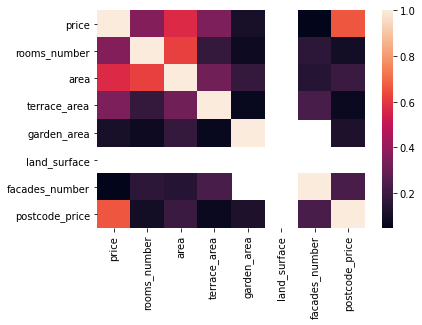

In [26]:
df_cleaned = df_cleaned.select_dtypes(include=float)
df_corr = df_cleaned.corr(method="pearson")
print(df_corr["price"].sort_values(ascending=False))
sns.heatmap(df_corr)
